### __HomeWork 11__
В якості домашнього завдання вам пропонується `створити рекурентну нейронну мережу` за допомогою механізмів `Keras`, яка буде `класифікувати рецензії із датасету imdb`.

На відміну від прикладу в модулі 9 ми використаємо рекурентну нейронну мережу. Поекспериментуйте з будовою мережі - `RNN`, `LSTM`, `двостороння` та `глибока`.

Порівняйте результати та зробіть висновки.

In [1]:
import os
import random

from keras.datasets import imdb
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Bidirectional, Dense, Embedding, LSTM, SimpleRNN
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
# def set_seed(seed_value: int) -> None:
#     """Set a random state for repeatability of results."""
#     random.seed(seed_value)
#     np.random.seed(seed_value)
#     tf.random.set_seed(seed_value)
#     os.environ['PYTHONHASHSEED'] = str(seed_value)
#     os.environ['TF_DETERMINISTIC_OPS'] = 'true'


# set_seed(1)

##### __`OBTAIN` & `SCRUB`__ + __`EXPLORE`__ (DATASET)

In [2]:
max_features = 10000  # кількість слів, що розглядаються як особливості
maxlen = 500  # обмеження кількості слів в тексті
# batch_size = 128  # розмір батчів

###### `pad_sequences`

In [3]:
# Завантаження тренувальних та тестових даних зі вказанням обмеження на кількість слів,
# залишимо лише ті слова, які зустрічаються не менше 10000 разів, більш рідкісні будуть проігноровані:
(input_train, labels_train), (input_test, labels_test) = imdb.load_data(num_words=max_features)

17464789/17464789 [==============================] - 0s 0us/step


In [4]:
print(input_train[0])  # цифри кодують текст рецензії

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [5]:
print(len(input_train[0]))

218


In [6]:
word_index = imdb.get_word_index()  # словник, у якому значення - це всі слова, які використовуються в рецензіях, а ключ – це ідентифікатор відповідного слова
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in input_train[10]])
# У словнику word_index ідентифікатори слів починаються з 3, так як значення 0, 1 та 2 зарезервовані для службових цілей.
print(decoded_review)

1641221/1641221 [==============================] - 0s 0us/step
? french horror cinema has seen something of a revival over the last couple of years with great films such as inside and ? romance ? on to the scene ? ? the revival just slightly but stands head and shoulders over most modern horror titles and is surely one of the best french horror films ever made ? was obviously shot on a low budget but this is made up for in far more ways than one by the originality of the film and this in turn is ? by the excellent writing and acting that ensure the film is a winner the plot focuses on two main ideas prison and black magic the central character is a man named ? sent to prison for fraud he is put in a cell with three others the quietly insane ? body building ? marcus and his retarded boyfriend daisy after a short while in the cell together they stumble upon a hiding place in the wall that contains an old ? after ? part of it they soon realise its magical powers and realise they may be ab

In [7]:
print(input_train.shape)
print(type(input_train[0]))
print(len(input_train[0]))

(25000,)
<class 'list'>
218


In [31]:
max([el.shape[0] for el in input_test])

500

In [32]:
min([el.shape[0] for el in input_test])

500

In [8]:
len(max(input_train.max(), input_test.max()))

374

In [9]:
len(min(input_train.min(), input_test.min()))

145

Різна довжина списків в кожній з 25000 комірок.

In [10]:
input_train.dtype, input_train.shape, input_test.dtype, input_test.shape

(dtype('O'), (25000,), dtype('O'), (25000,))

- https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences

In [11]:
# Передпроцесинг послідовних даних:
input_train = pad_sequences(input_train, maxlen=maxlen)
input_test = pad_sequences(input_test, maxlen=maxlen)
# Застосування заздалегідь обраної максимальної довжини до послідовних даних тренувального та тестового наборів

In [12]:
input_train.shape, input_test.shape

((25000, 500), (25000, 500))

In [13]:
max(input_train.max(), input_test.max())  # +`0` = 10000 (бо в наших послідовностях це буде максимально можливе значення)

9999

In [14]:
NUM_CLASSES = len(set(np.concatenate((labels_train, labels_test), axis=0)))  # 2
NUM_CLASSES

2

In [15]:
input_train.shape, input_test.shape, labels_train.shape, labels_test.shape

((25000, 500), (25000, 500), (25000,), (25000,))

##### __`MODEL`__

- https://keras.io/api/layers/core_layers/embedding/

In [ ]:
def simple_RNN(neurons: int, final_act: str='sigmoid', add_to_name: str='') -> Sequential:
    model = Sequential(name=f'''SimpleRNN-{neurons}-{final_act}-{add_to_name}''')
    # Створення порожньої моделі Sequential

    # Додавання Embedding шару для перетворення слів в вектори фіксованої довжини
    model.add(Embedding(max_features, 32))
    # Параметри: кількість слів для розгляду як особливості та розмір вектора, що представляє кожне слово

    # Додавання SimpleRNN шару з neurons вузлами
    model.add(SimpleRNN(neurons))
    # Параметр: кількість вузлів (розмір прихованого стану)

    # Додавання Dense шару з одним вузлом та активацією sigmoid
    model.add(Dense(1, activation=final_act))
    # Параметри: кількість вузлів (вихідний розмір) та функція активації (sigmoid для бінарної класифікації)

    return model

In [ ]:
def model_LSTM(neurons: int, final_act: str='sigmoid', add_to_name: str='') -> Sequential:
    model = Sequential(name=f'''RNN-LSTM-{neurons}-{final_act}-{add_to_name}''')
    # Створення порожньої моделі Sequential

    # Додавання Embedding шару для перетворення слів в вектори фіксованої довжини
    model.add(Embedding(max_features, 32))
    # Параметри: кількість слів для розгляду як особливості та розмір вектора, що представляє кожне слово

    model.add(LSTM(neurons))

    # Додавання Dense шару з одним вузлом та активацією sigmoid
    model.add(Dense(1, activation=final_act))
    # Параметри: кількість вузлів (вихідний розмір) та функція активації (sigmoid для бінарної класифікації)

    return model

In [ ]:
def model_BRNN(neurons: int, final_act: str='sigmoid', add_to_name: str='') -> Sequential:
    model = Sequential(name=f'''BRNN-{neurons}-{final_act}-{add_to_name}''')
    # Створення порожньої моделі Sequential

    # Додавання Embedding шару для перетворення слів в вектори фіксованої довжини
    model.add(Embedding(max_features, 32))
    # Параметри: кількість слів для розгляду як особливості та розмір вектора, що представляє кожне слово

    model.add(Bidirectional(LSTM(neurons)))

    # Додавання Dense шару з одним вузлом та активацією sigmoid
    model.add(Dense(1, activation=final_act))
    # Параметри: кількість вузлів (вихідний розмір) та функція активації (sigmoid для бінарної класифікації)

    return model

In [ ]:
def model_DRNN(neurons: int, final_act: str='sigmoid', add_to_name: str='') -> Sequential:
    model = Sequential(name=f'''DRNN-{neurons}-{final_act}-{add_to_name}''')
    # Створення порожньої моделі Sequential

    # Додавання Embedding шару для перетворення слів в вектори фіксованої довжини
    model.add(Embedding(max_features, 32))
    # Параметри: кількість слів для розгляду як особливості та розмір вектора, що представляє кожне слово

    model.add(Bidirectional(LSTM(neurons, return_sequences=True)))
    model.add(Bidirectional(LSTM(neurons)))

    # Додавання Dense шару з одним вузлом та активацією sigmoid
    model.add(Dense(1, activation=final_act))
    # Параметри: кількість вузлів (вихідний розмір) та функція активації (sigmoid для бінарної класифікації)

    return model

In [ ]:
neurons = [8, 16, 32, 64]
optimizers = ['rmsprop', 'adam']

In [ ]:
simple_RNN_models = []
models_RNN_LSTM = []
models_BRNN = []
models_DRNN = []
for n in neurons:
    for opt in optimizers:
        model = simple_RNN(n, add_to_name=opt)
        model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
        simple_RNN_models.append(model)

        model2 = model_LSTM(n, add_to_name=opt)
        model2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
        models_RNN_LSTM.append(model2)

        model3 = model_BRNN(n, add_to_name=opt)
        model3.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
        models_BRNN.append(model3)

        model4 = model_DRNN(n, add_to_name=opt)
        model4.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
        models_DRNN.append(model4)

In [ ]:
[print(model.summary()) for model in simple_RNN_models]

Model: "SimpleRNN-8-sigmoid-rmsprop"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_119 (Embedding)   (None, None, 32)          320000    
                                                                 
 simple_rnn_97 (SimpleRNN)   (None, 8)                 328       
                                                                 
 dense_115 (Dense)           (None, 1)                 9         
                                                                 
Total params: 320337 (1.22 MB)
Trainable params: 320337 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "SimpleRNN-8-sigmoid-adam"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_123 (Embedding)   (None, None, 32)          320000    
                              

[None, None, None, None, None, None, None, None]

##### `Training`

- https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
- https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

In [ ]:
# history = simple_RNN_models[0].fit(input_train, labels_train, epochs=5, batch_size=128, validation_split=0.3)

##### __`INTERPRET`__ / __`Error Analysis`__

обмежимося 5 епохами та роміром батчів 128

In [ ]:
from keras.src.callbacks import History


def draw_history(history: History) -> None:
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Точність на тренуванні')  # Графік точності на тренувальних данних
    plt.plot(epochs, val_acc, 'g', label='Точність на валідації')  # Графік точності на валідаційних данних
    plt.title('Точність тренування і валідації')  # Заголовок графіку
    plt.legend()  # Показати легенду

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Втрати на тренуванні')  # Графік втрат на тренувальних данних
    plt.plot(epochs, val_loss, 'g', label='Втрати на валідації')  # Графік втрат на валідаційних данних
    plt.title('Втрати тренування і валідації')  # Заголовок графіку
    plt.legend()  # Показати легенду

    plt.show()  # Відобразити графіки

In [ ]:
def predictions_by_model(model: Sequential, x_test: np.ndarray, y_test: np.ndarray) -> float:
    predictions = model.predict(x_test)

    # Для отримання зрозумілішого вигляду прогнозів, їх можна перетворити в бінарний формат:
    binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

    # Для порівняння можна вивести деякі(перші 10) прогнозовані значення поряд з фактичними значеннями
    for i in range(10):
        print(f'Прогнозоване: {binary_predictions[i]}, Фактичне: {y_test[i]}')

    print('...')
    print(f'= {model.name}:')

    # Додатковий крок: Оцінка моделі
    # Це дасть загальну точність моделі на тестових даних
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}')

    return test_acc

##### __`RE-TEST`__

In [ ]:
def models_training(models: list, input_train: np.ndarray, labels_train: np.ndarray, epochs: int=5, batch_size: int=128) -> tuple:
    model_acc_by_test = {}
    all_models_and_history = []
    for model in models:
        print(f'\n{model.name.upper()}:')
        history = model.fit(input_train, labels_train, epochs=5, batch_size=128, validation_split=0.3)
        all_models_and_history.append((model, history))
        # Запускаємо навчання моделі на тренувальних даних для 5 епох з розміром пакету 128 та розбиттям на тренувальну та валідаційну підмножини
        # validation_split = This argument is not supported when x is a dataset, generator or keras.utils.Sequence instance.

    return all_models_and_history, model_acc_by_test

In [ ]:
all_models_and_history_simple, model_acc_by_test_simple = models_training(simple_RNN_models, input_train, labels_train)


SIMPLERNN-8-SIGMOID-RMSPROP:
Epoch 1/5


137/137 [==============================] - 11s 73ms/step - loss: 0.6831 - acc: 0.5541 - val_loss: 0.6667 - val_acc: 0.5977
Epoch 2/5
137/137 [==============================] - 10s 72ms/step - loss: 0.5987 - acc: 0.7191 - val_loss: 0.5630 - val_acc: 0.7252
Epoch 3/5
137/137 [==============================] - 10s 73ms/step - loss: 0.4337 - acc: 0.8165 - val_loss: 0.4757 - val_acc: 0.7941
Epoch 4/5
137/137 [==============================] - 10s 72ms/step - loss: 0.3348 - acc: 0.8727 - val_loss: 0.4172 - val_acc: 0.8225
Epoch 5/5
137/137 [==============================] - 10s 73ms/step - loss: 0.2602 - acc: 0.9042 - val_loss: 0.4051 - val_acc: 0.8296

SIMPLERNN-8-SIGMOID-ADAM:
Epoch 1/5
137/137 [==============================] - 11s 74ms/step - loss: 0.6721 - acc: 0.5882 - val_loss: 0.6053 - val_acc: 0.7188
Epoch 2/5
137/137 [==============================] - 10s 73ms/step - loss: 0.4893 - acc: 0.8078 - val_loss: 0.4689 - val_acc: 0.7985
Epoch 3/5
137/137 [==============================] -


SIMPLERNN-8-SIGMOID-RMSPROP:


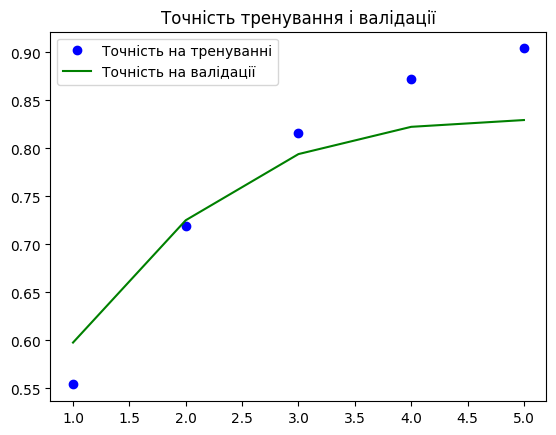

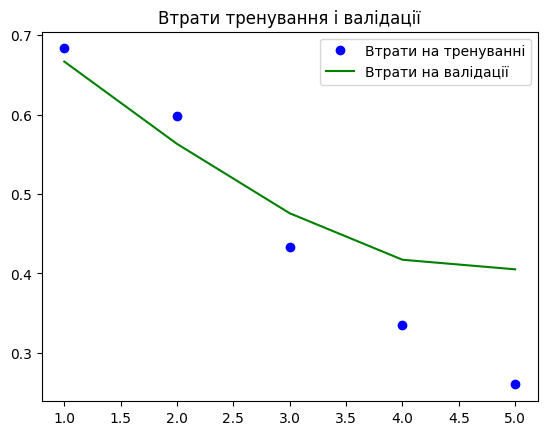

782/782 [==============================] - 10s 13ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
...
= SimpleRNN-8-sigmoid-rmsprop:
782/782 [==============================] - 10s 13ms/step - loss: 0.4083 - acc: 0.8286
Test Loss: 0.4083
Test Accuracy: 0.8286

SIMPLERNN-8-SIGMOID-ADAM:


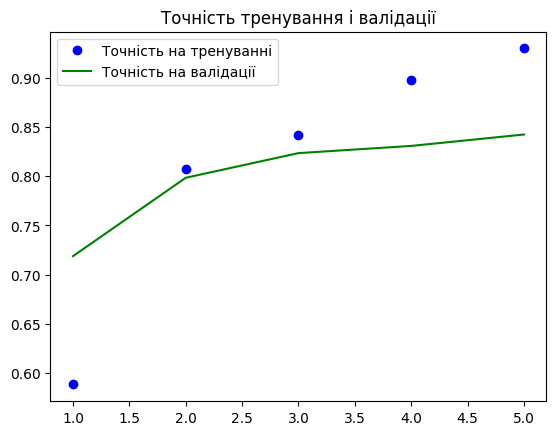

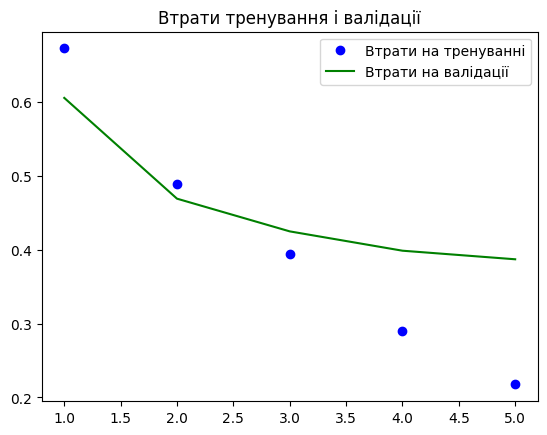

782/782 [==============================] - 10s 13ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
...
= SimpleRNN-8-sigmoid-adam:
782/782 [==============================] - 10s 13ms/step - loss: 0.3949 - acc: 0.8389
Test Loss: 0.3949
Test Accuracy: 0.8389

SIMPLERNN-16-SIGMOID-RMSPROP:


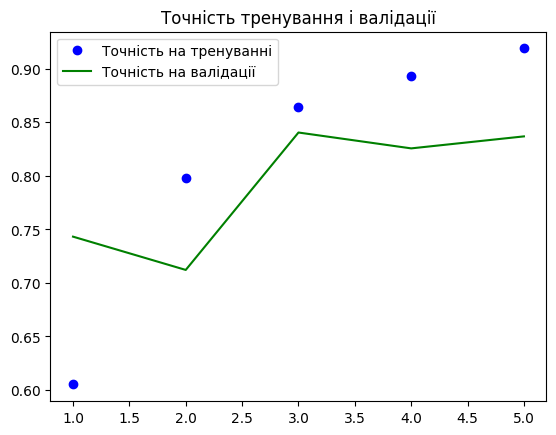

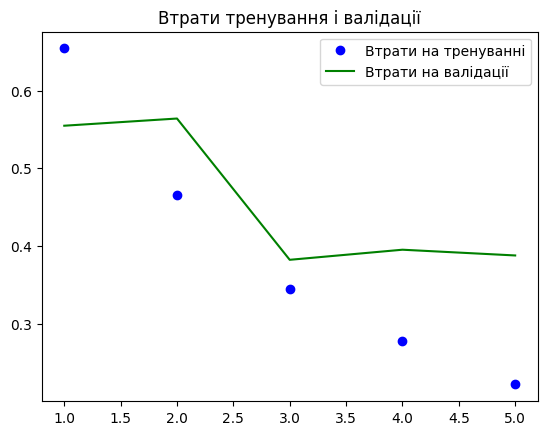

782/782 [==============================] - 11s 14ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
...
= SimpleRNN-16-sigmoid-rmsprop:
782/782 [==============================] - 11s 14ms/step - loss: 0.3943 - acc: 0.8342
Test Loss: 0.3943
Test Accuracy: 0.8342

SIMPLERNN-16-SIGMOID-ADAM:


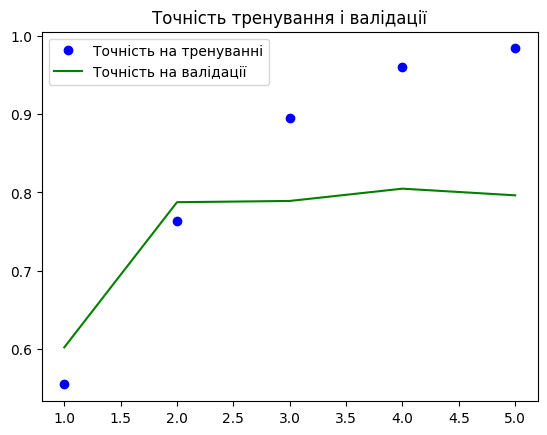

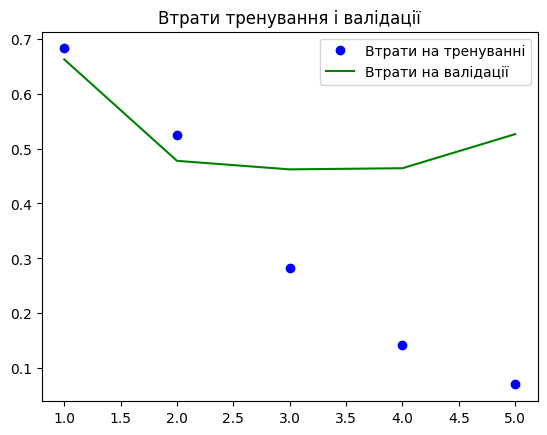

782/782 [==============================] - 10s 13ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 0, Фактичне: 1
...
= SimpleRNN-16-sigmoid-adam:
782/782 [==============================] - 10s 13ms/step - loss: 0.5302 - acc: 0.7906
Test Loss: 0.5302
Test Accuracy: 0.7906

SIMPLERNN-32-SIGMOID-RMSPROP:


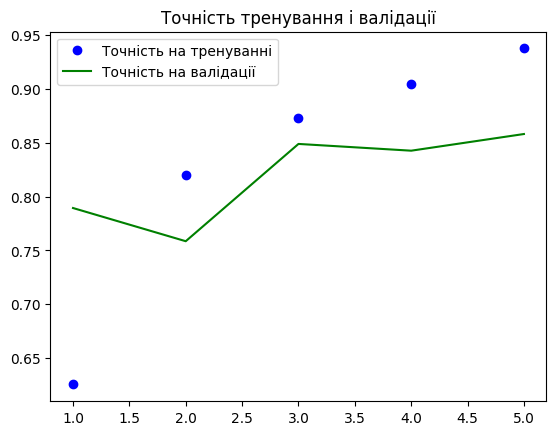

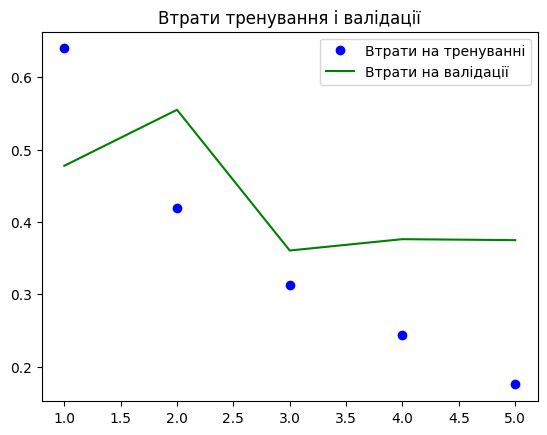

782/782 [==============================] - 11s 14ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
...
= SimpleRNN-32-sigmoid-rmsprop:
782/782 [==============================] - 12s 15ms/step - loss: 0.3873 - acc: 0.8531
Test Loss: 0.3873
Test Accuracy: 0.8531

SIMPLERNN-32-SIGMOID-ADAM:


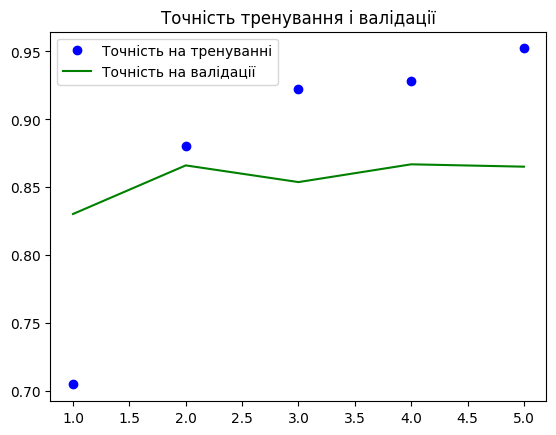

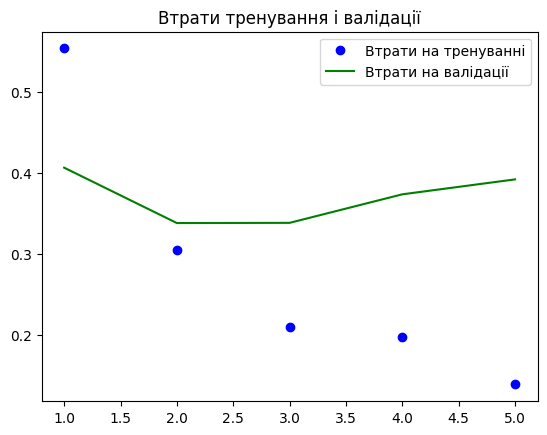

782/782 [==============================] - 11s 14ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
...
= SimpleRNN-32-sigmoid-adam:
782/782 [==============================] - 12s 15ms/step - loss: 0.4342 - acc: 0.8497
Test Loss: 0.4342
Test Accuracy: 0.8497

SIMPLERNN-64-SIGMOID-RMSPROP:


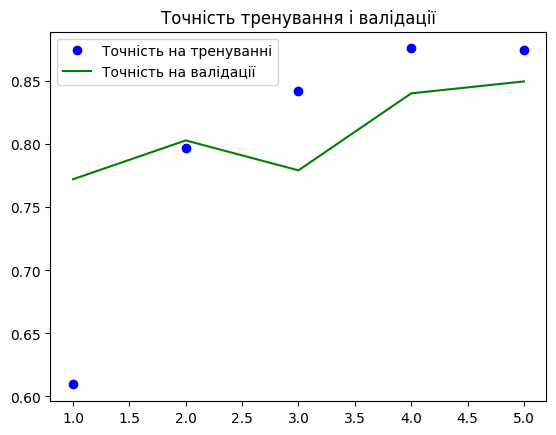

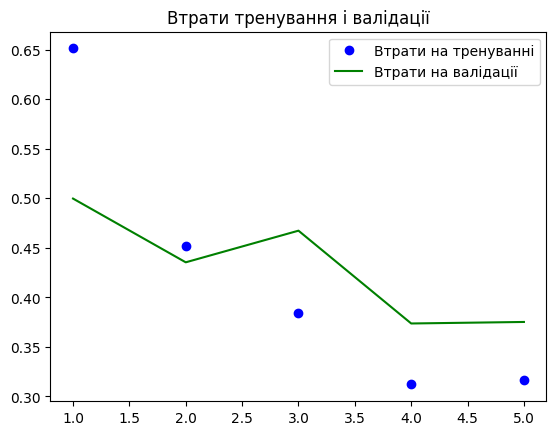

782/782 [==============================] - 12s 15ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
...
= SimpleRNN-64-sigmoid-rmsprop:
782/782 [==============================] - 12s 15ms/step - loss: 0.3771 - acc: 0.8475
Test Loss: 0.3771
Test Accuracy: 0.8475

SIMPLERNN-64-SIGMOID-ADAM:


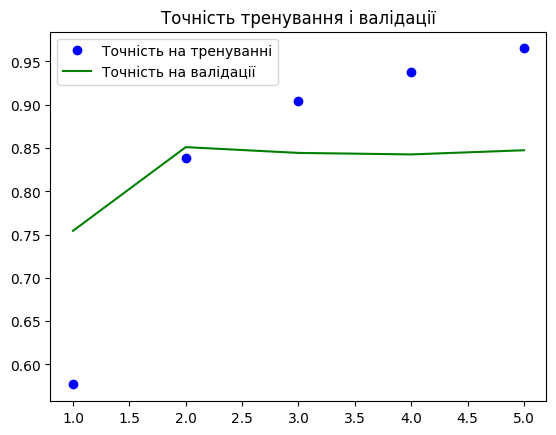

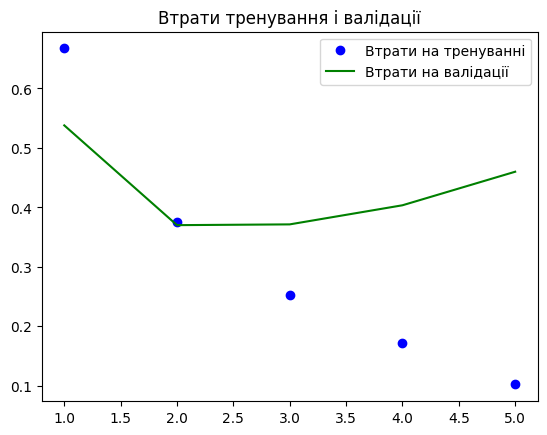

782/782 [==============================] - 12s 15ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
...
= SimpleRNN-64-sigmoid-adam:
782/782 [==============================] - 12s 15ms/step - loss: 0.4817 - acc: 0.8391
Test Loss: 0.4817
Test Accuracy: 0.8391


In [ ]:
for model, history in all_models_and_history_simple:
    print(f'\n{model.name.upper()}:')
    draw_history(history)
    model_acc_by_test_simple[model.name] = predictions_by_model(model, input_test, labels_test)

In [ ]:
model_acc_by_test_simple

{'SimpleRNN-8-sigmoid-rmsprop': 0.8286399841308594,
 'SimpleRNN-8-sigmoid-adam': 0.8388800024986267,
 'SimpleRNN-16-sigmoid-rmsprop': 0.8342400193214417,
 'SimpleRNN-16-sigmoid-adam': 0.7906000018119812,
 'SimpleRNN-32-sigmoid-rmsprop': 0.8530799746513367,
 'SimpleRNN-32-sigmoid-adam': 0.8496800065040588,
 'SimpleRNN-64-sigmoid-rmsprop': 0.8475199937820435,
 'SimpleRNN-64-sigmoid-adam': 0.8390799760818481}

In [ ]:
all_models_and_history_LSTM, model_acc_by_test_LSTM = models_training(models_RNN_LSTM, input_train, labels_train)


RNN-LSTM-8-SIGMOID-RMSPROP:
Epoch 1/5


137/137 [==============================] - 19s 122ms/step - loss: 0.6659 - acc: 0.6143 - val_loss: 0.5449 - val_acc: 0.7467
Epoch 2/5
137/137 [==============================] - 16s 118ms/step - loss: 0.4644 - acc: 0.8057 - val_loss: 0.4304 - val_acc: 0.8207
Epoch 3/5
137/137 [==============================] - 16s 119ms/step - loss: 0.3533 - acc: 0.8669 - val_loss: 0.3648 - val_acc: 0.8528
Epoch 4/5
137/137 [==============================] - 16s 118ms/step - loss: 0.2844 - acc: 0.8957 - val_loss: 0.3345 - val_acc: 0.8628
Epoch 5/5
137/137 [==============================] - 16s 119ms/step - loss: 0.2407 - acc: 0.9145 - val_loss: 0.3188 - val_acc: 0.8756

RNN-LSTM-8-SIGMOID-ADAM:
Epoch 1/5
137/137 [==============================] - 18s 122ms/step - loss: 0.5866 - acc: 0.7257 - val_loss: 0.4832 - val_acc: 0.8152
Epoch 2/5
137/137 [==============================] - 16s 119ms/step - loss: 0.4002 - acc: 0.8657 - val_loss: 0.3949 - val_acc: 0.8509
Epoch 3/5
137/137 [===========================


RNN-LSTM-8-SIGMOID-RMSPROP:


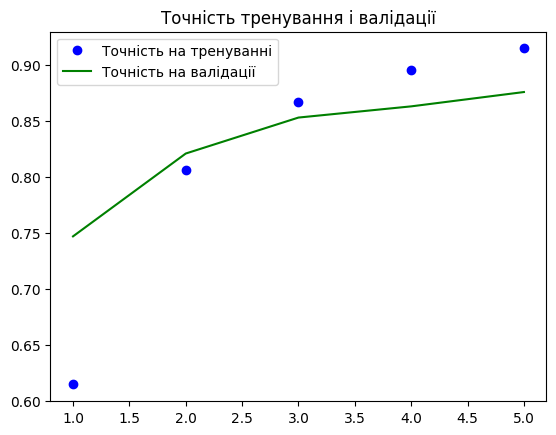

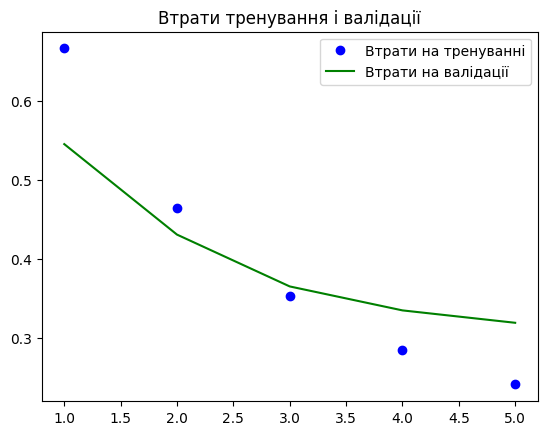

782/782 [==============================] - 15s 19ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
...
= RNN-LSTM-8-sigmoid-rmsprop:
782/782 [==============================] - 15s 19ms/step - loss: 0.3301 - acc: 0.8680
Test Loss: 0.3301
Test Accuracy: 0.8680

RNN-LSTM-8-SIGMOID-ADAM:


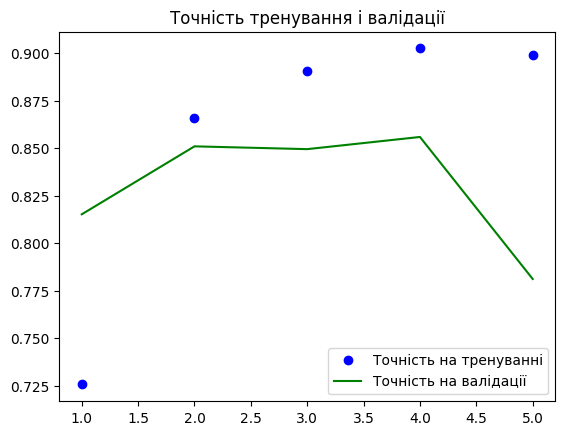

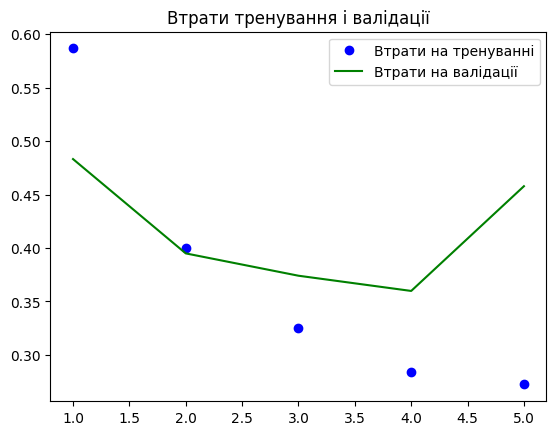

782/782 [==============================] - 15s 18ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
...
= RNN-LSTM-8-sigmoid-adam:
782/782 [==============================] - 15s 19ms/step - loss: 0.4544 - acc: 0.7889
Test Loss: 0.4544
Test Accuracy: 0.7889

RNN-LSTM-16-SIGMOID-RMSPROP:


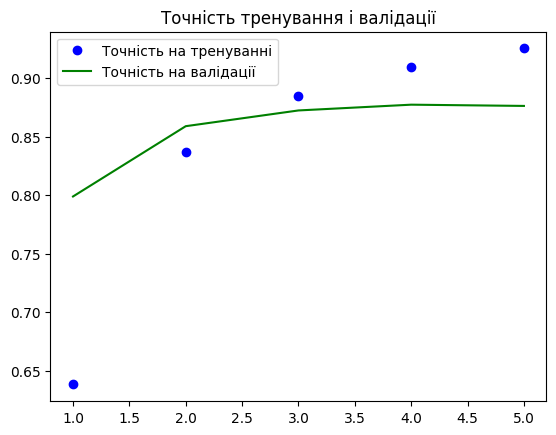

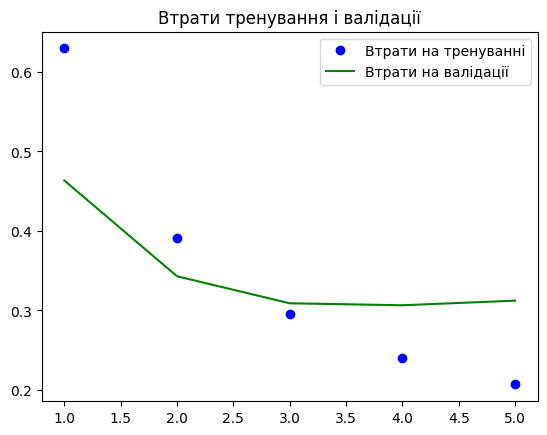

782/782 [==============================] - 15s 19ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
...
= RNN-LSTM-16-sigmoid-rmsprop:
782/782 [==============================] - 15s 20ms/step - loss: 0.3274 - acc: 0.8696
Test Loss: 0.3274
Test Accuracy: 0.8696

RNN-LSTM-16-SIGMOID-ADAM:


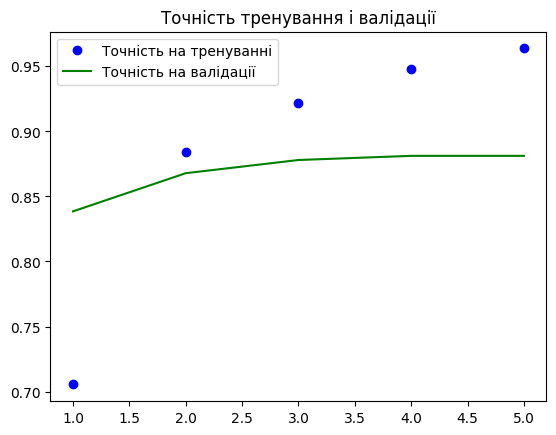

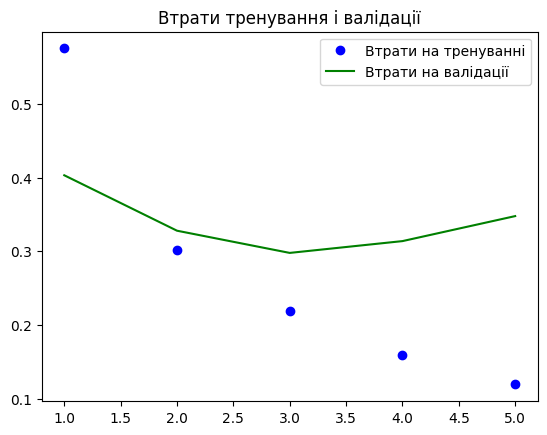

782/782 [==============================] - 16s 19ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
...
= RNN-LSTM-16-sigmoid-adam:
782/782 [==============================] - 15s 20ms/step - loss: 0.3834 - acc: 0.8666
Test Loss: 0.3834
Test Accuracy: 0.8666

RNN-LSTM-32-SIGMOID-RMSPROP:


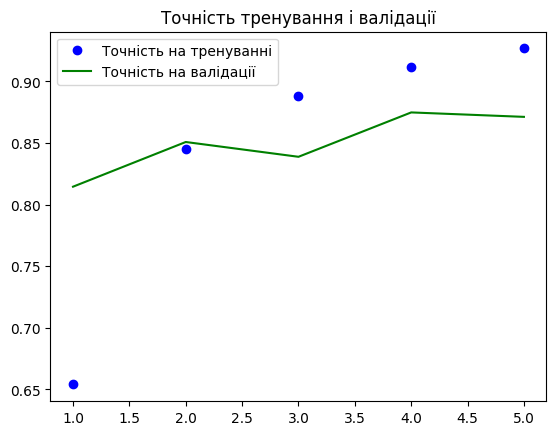

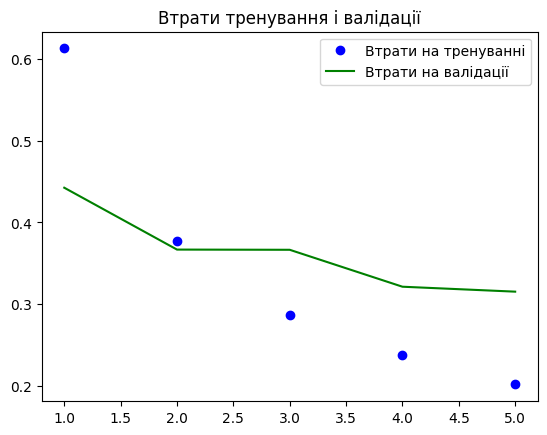

782/782 [==============================] - 19s 25ms/step
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
...
= RNN-LSTM-32-sigmoid-rmsprop:
782/782 [==============================] - 19s 25ms/step - loss: 0.3277 - acc: 0.8674
Test Loss: 0.3277
Test Accuracy: 0.8674

RNN-LSTM-32-SIGMOID-ADAM:


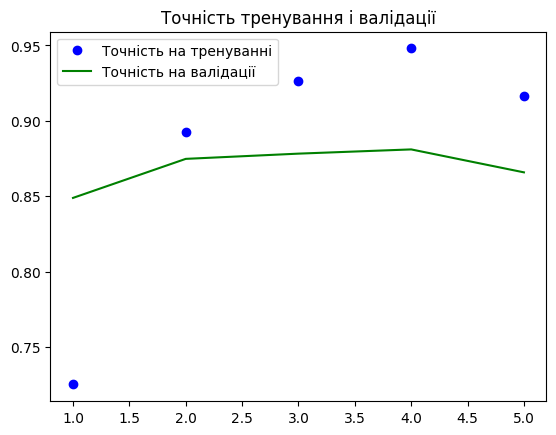

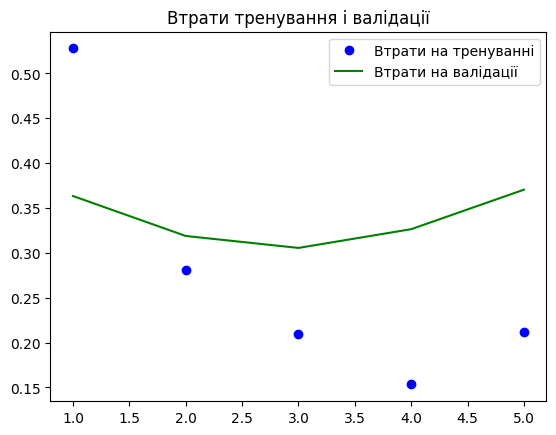

782/782 [==============================] - 20s 25ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
...
= RNN-LSTM-32-sigmoid-adam:
782/782 [==============================] - 19s 25ms/step - loss: 0.3866 - acc: 0.8551
Test Loss: 0.3866
Test Accuracy: 0.8551

RNN-LSTM-64-SIGMOID-RMSPROP:


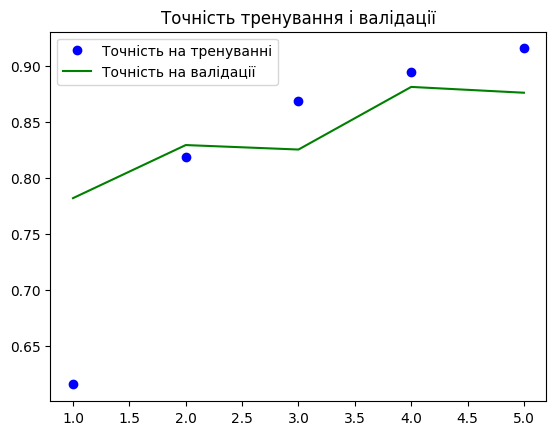

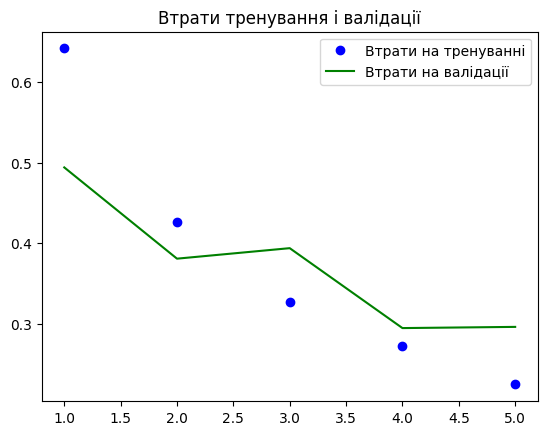

782/782 [==============================] - 28s 36ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
...
= RNN-LSTM-64-sigmoid-rmsprop:
782/782 [==============================] - 28s 36ms/step - loss: 0.3068 - acc: 0.8746
Test Loss: 0.3068
Test Accuracy: 0.8746

RNN-LSTM-64-SIGMOID-ADAM:


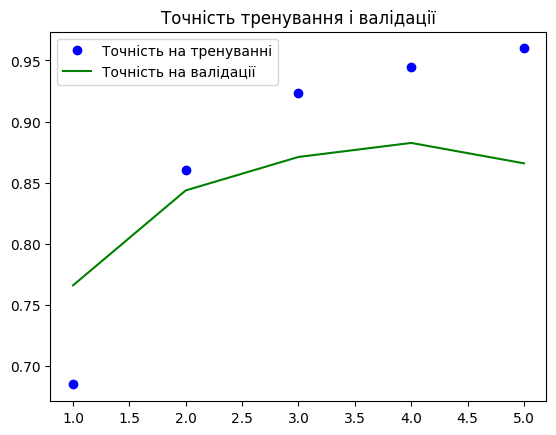

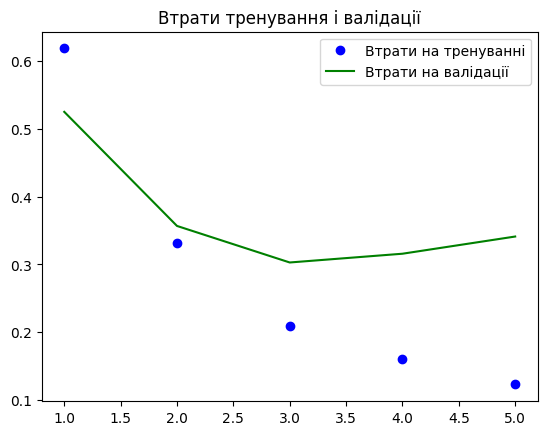

782/782 [==============================] - 28s 36ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
...
= RNN-LSTM-64-sigmoid-adam:
782/782 [==============================] - 28s 36ms/step - loss: 0.3568 - acc: 0.8580
Test Loss: 0.3568
Test Accuracy: 0.8580


In [ ]:
for model, history in all_models_and_history_LSTM:
    print(f'\n{model.name.upper()}:')
    draw_history(history)
    model_acc_by_test_LSTM[model.name] = predictions_by_model(model, input_test, labels_test)

In [ ]:
model_acc_by_test_LSTM

{'RNN-LSTM-8-sigmoid-rmsprop': 0.8679599761962891,
 'RNN-LSTM-8-sigmoid-adam': 0.788919985294342,
 'RNN-LSTM-16-sigmoid-rmsprop': 0.8696399927139282,
 'RNN-LSTM-16-sigmoid-adam': 0.866599977016449,
 'RNN-LSTM-32-sigmoid-rmsprop': 0.86735999584198,
 'RNN-LSTM-32-sigmoid-adam': 0.8550800085067749,
 'RNN-LSTM-64-sigmoid-rmsprop': 0.8745999932289124,
 'RNN-LSTM-64-sigmoid-adam': 0.8580399751663208}

In [ ]:
all_models_and_history_BRNN, model_acc_by_test_BRNN = models_training(models_BRNN, input_train, labels_train)


BRNN-8-SIGMOID-RMSPROP:
Epoch 1/5


137/137 [==============================] - 23s 152ms/step - loss: 0.6368 - acc: 0.6486 - val_loss: 0.5370 - val_acc: 0.7559
Epoch 2/5
137/137 [==============================] - 20s 149ms/step - loss: 0.4451 - acc: 0.8286 - val_loss: 0.4187 - val_acc: 0.8379
Epoch 3/5
137/137 [==============================] - 20s 149ms/step - loss: 0.3409 - acc: 0.8766 - val_loss: 0.3527 - val_acc: 0.8604
Epoch 4/5
137/137 [==============================] - 20s 148ms/step - loss: 0.2737 - acc: 0.9027 - val_loss: 0.3185 - val_acc: 0.8729
Epoch 5/5
137/137 [==============================] - 20s 148ms/step - loss: 0.2316 - acc: 0.9198 - val_loss: 0.3336 - val_acc: 0.8656

BRNN-8-SIGMOID-ADAM:
Epoch 1/5
137/137 [==============================] - 23s 153ms/step - loss: 0.5901 - acc: 0.6982 - val_loss: 0.4584 - val_acc: 0.8277
Epoch 2/5
137/137 [==============================] - 20s 148ms/step - loss: 0.3857 - acc: 0.8576 - val_loss: 0.3782 - val_acc: 0.8504
Epoch 3/5
137/137 [==============================]


BRNN-8-SIGMOID-RMSPROP:


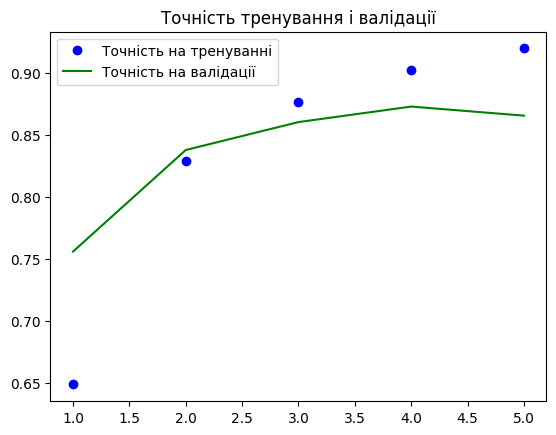

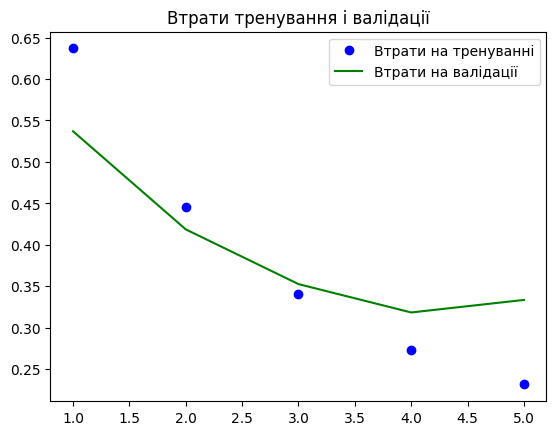

782/782 [==============================] - 19s 23ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
...
= BRNN-8-sigmoid-rmsprop:
782/782 [==============================] - 18s 23ms/step - loss: 0.3471 - acc: 0.8583
Test Loss: 0.3471
Test Accuracy: 0.8583

BRNN-8-SIGMOID-ADAM:


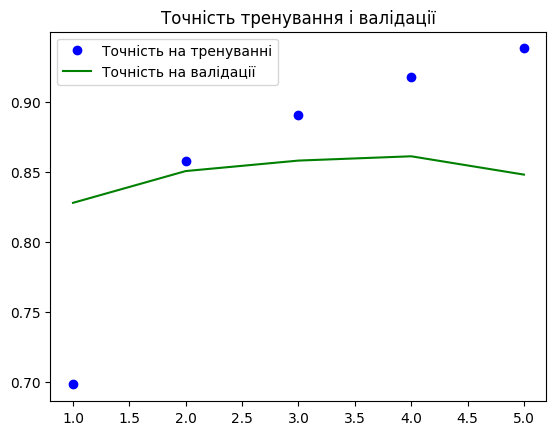

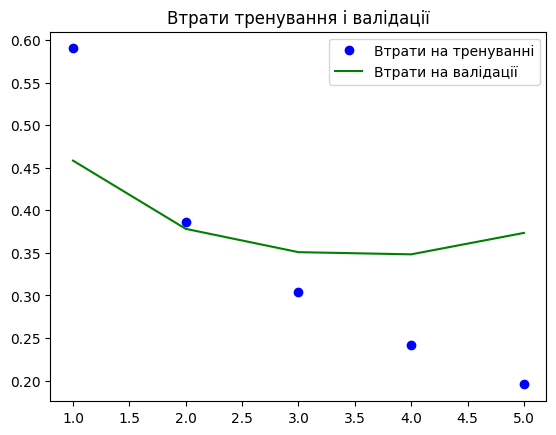

782/782 [==============================] - 18s 23ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
...
= BRNN-8-sigmoid-adam:
782/782 [==============================] - 18s 23ms/step - loss: 0.3839 - acc: 0.8418
Test Loss: 0.3839
Test Accuracy: 0.8418

BRNN-16-SIGMOID-RMSPROP:


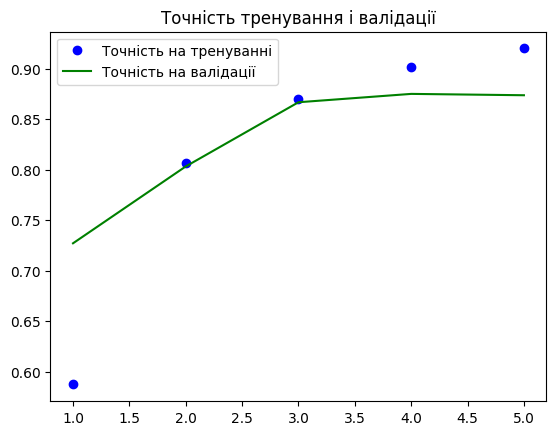

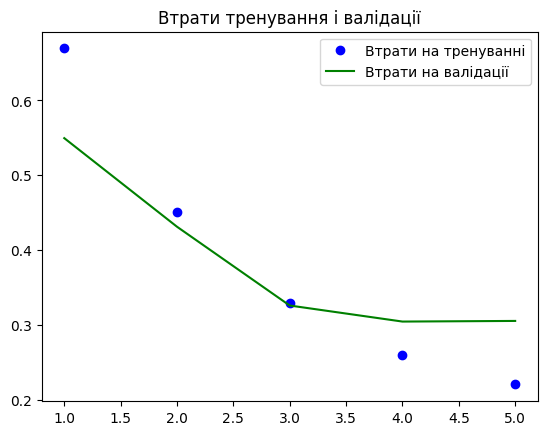

782/782 [==============================] - 20s 25ms/step
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
...
= BRNN-16-sigmoid-rmsprop:
782/782 [==============================] - 20s 25ms/step - loss: 0.3095 - acc: 0.8718
Test Loss: 0.3095
Test Accuracy: 0.8718

BRNN-16-SIGMOID-ADAM:


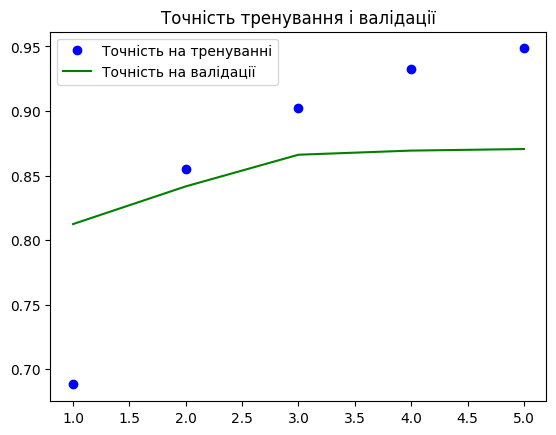

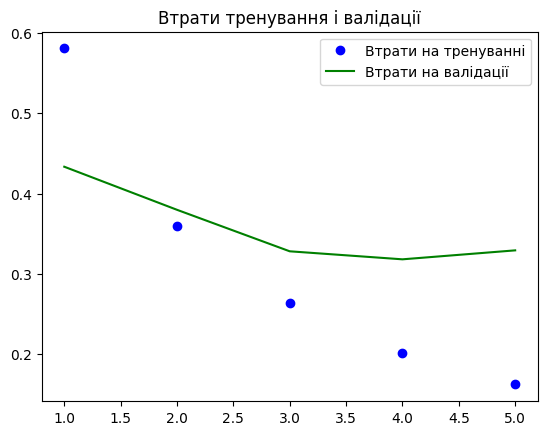

782/782 [==============================] - 20s 25ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
...
= BRNN-16-sigmoid-adam:
782/782 [==============================] - 20s 25ms/step - loss: 0.3491 - acc: 0.8645
Test Loss: 0.3491
Test Accuracy: 0.8645

BRNN-32-SIGMOID-RMSPROP:


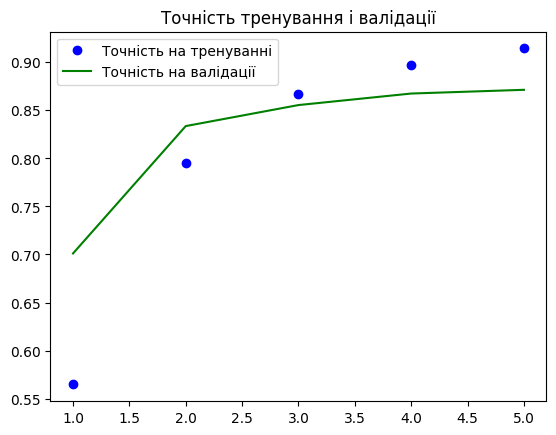

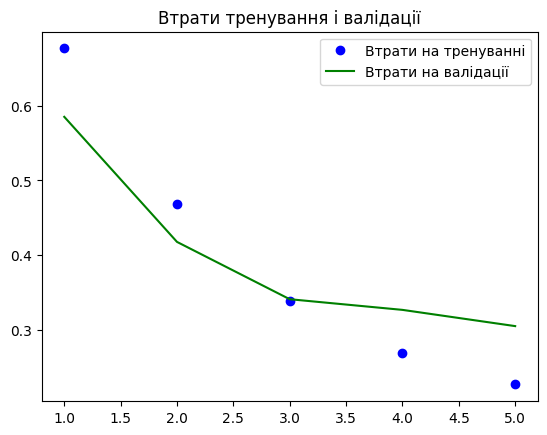

782/782 [==============================] - 24s 30ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
...
= BRNN-32-sigmoid-rmsprop:
782/782 [==============================] - 24s 30ms/step - loss: 0.3135 - acc: 0.8672
Test Loss: 0.3135
Test Accuracy: 0.8672

BRNN-32-SIGMOID-ADAM:


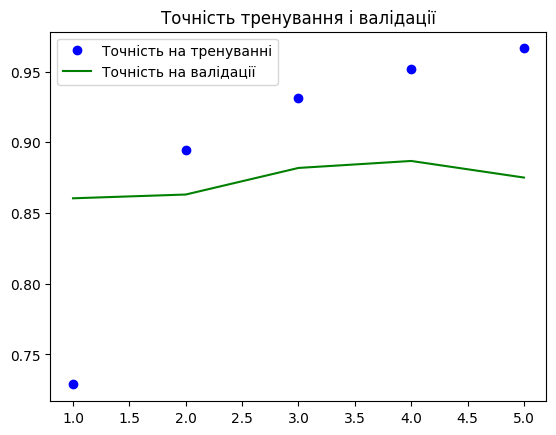

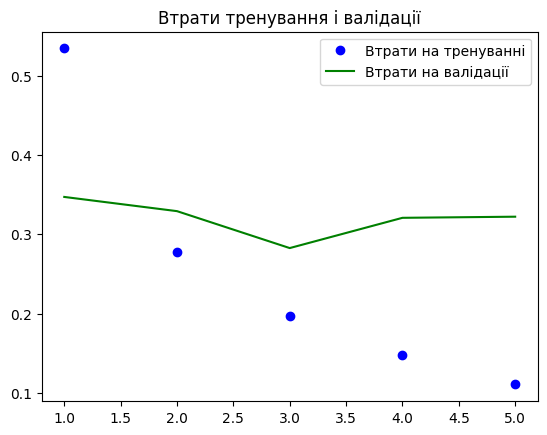

782/782 [==============================] - 24s 30ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
...
= BRNN-32-sigmoid-adam:
782/782 [==============================] - 24s 31ms/step - loss: 0.3576 - acc: 0.8633
Test Loss: 0.3576
Test Accuracy: 0.8633

BRNN-64-SIGMOID-RMSPROP:


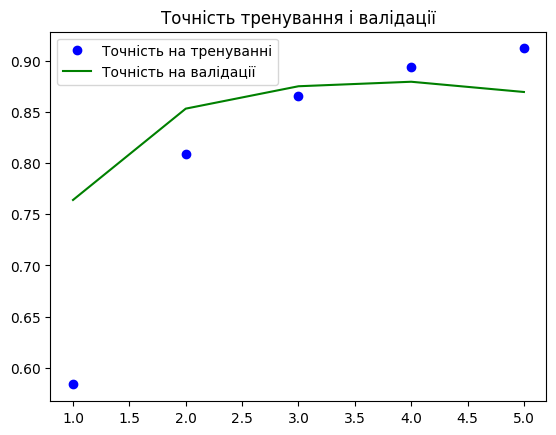

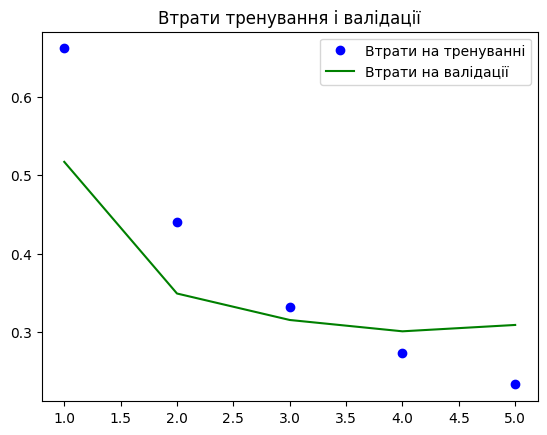

782/782 [==============================] - 35s 44ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
...
= BRNN-64-sigmoid-rmsprop:
782/782 [==============================] - 35s 44ms/step - loss: 0.3123 - acc: 0.8704
Test Loss: 0.3123
Test Accuracy: 0.8704

BRNN-64-SIGMOID-ADAM:


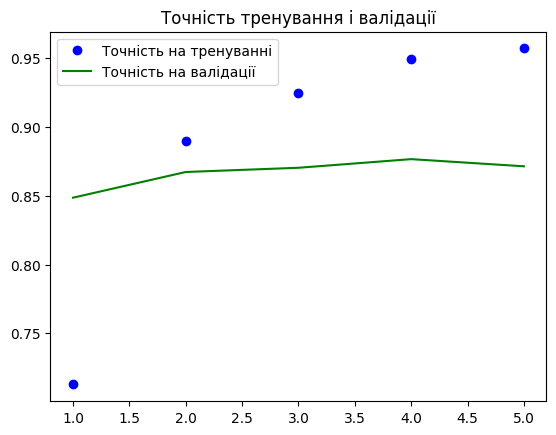

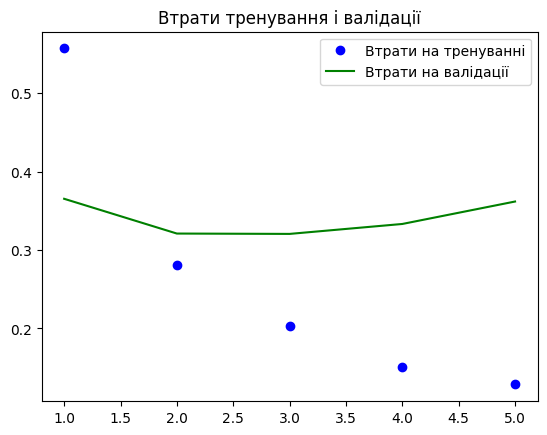

782/782 [==============================] - 35s 44ms/step
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
...
= BRNN-64-sigmoid-adam:
782/782 [==============================] - 34s 44ms/step - loss: 0.3911 - acc: 0.8580
Test Loss: 0.3911
Test Accuracy: 0.8580


In [ ]:
for model, history in all_models_and_history_BRNN:
    print(f'\n{model.name.upper()}:')
    draw_history(history)
    model_acc_by_test_BRNN[model.name] = predictions_by_model(model, input_test, labels_test)

In [ ]:
model_acc_by_test_BRNN

{'BRNN-8-sigmoid-rmsprop': 0.8583199977874756,
 'BRNN-8-sigmoid-adam': 0.8418400287628174,
 'BRNN-16-sigmoid-rmsprop': 0.8718400001525879,
 'BRNN-16-sigmoid-adam': 0.8644800186157227,
 'BRNN-32-sigmoid-rmsprop': 0.8672400116920471,
 'BRNN-32-sigmoid-adam': 0.8632799983024597,
 'BRNN-64-sigmoid-rmsprop': 0.8704000115394592,
 'BRNN-64-sigmoid-adam': 0.8579999804496765}

In [ ]:
all_models_and_history_DRNN, model_acc_by_test_DRNN = models_training(models_DRNN, input_train, labels_train)


DRNN-8-SIGMOID-RMSPROP:
Epoch 1/5
137/137 [==============================] - 44s 296ms/step - loss: 0.6732 - acc: 0.5809 - val_loss: 0.5713 - val_acc: 0.7176
Epoch 2/5
137/137 [==============================] - 40s 291ms/step - loss: 0.4673 - acc: 0.7971 - val_loss: 0.5153 - val_acc: 0.7728
Epoch 3/5
137/137 [==============================] - 40s 290ms/step - loss: 0.3603 - acc: 0.8587 - val_loss: 0.3573 - val_acc: 0.8575
Epoch 4/5
137/137 [==============================] - 40s 290ms/step - loss: 0.2836 - acc: 0.8965 - val_loss: 0.3342 - val_acc: 0.8580
Epoch 5/5
137/137 [==============================] - 40s 291ms/step - loss: 0.2327 - acc: 0.9179 - val_loss: 0.3696 - val_acc: 0.8443

DRNN-8-SIGMOID-ADAM:
Epoch 1/5
137/137 [==============================] - 45s 300ms/step - loss: 0.5575 - acc: 0.6985 - val_loss: 0.3796 - val_acc: 0.8507
Epoch 2/5
137/137 [==============================] - 40s 293ms/step - loss: 0.2910 - acc: 0.8927 - val_loss: 0.3224 - val_acc: 0.8733
Epoch 3/5
137/1


DRNN-8-SIGMOID-RMSPROP:


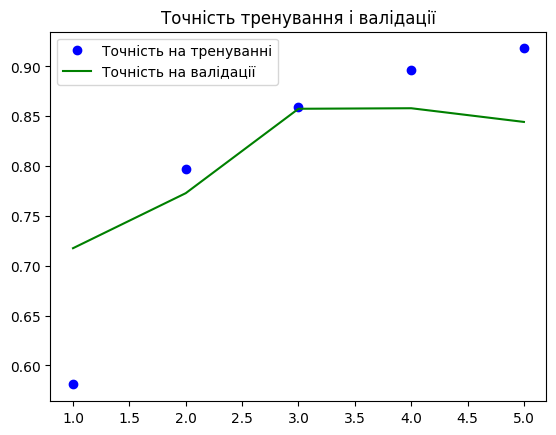

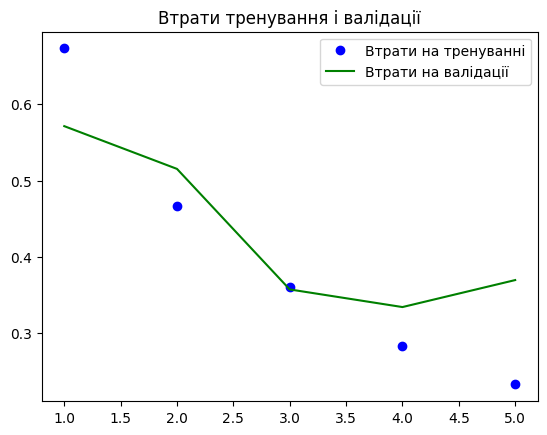

782/782 [==============================] - 35s 44ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
...
= DRNN-8-sigmoid-rmsprop:
782/782 [==============================] - 35s 44ms/step - loss: 0.3700 - acc: 0.8470
Test Loss: 0.3700
Test Accuracy: 0.8470

DRNN-8-SIGMOID-ADAM:


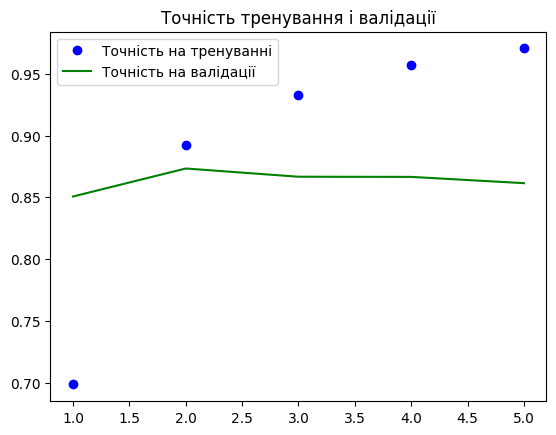

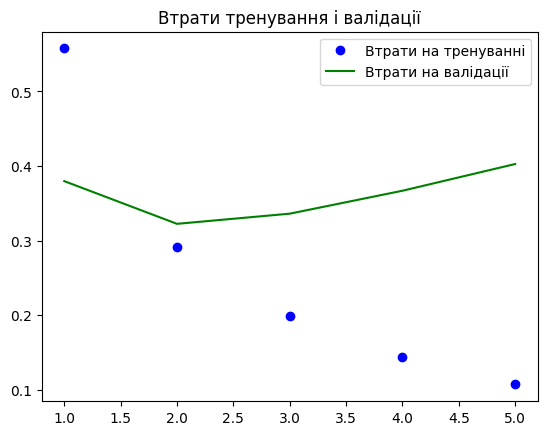

782/782 [==============================] - 35s 44ms/step
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
...
= DRNN-8-sigmoid-adam:
782/782 [==============================] - 35s 45ms/step - loss: 0.4153 - acc: 0.8602
Test Loss: 0.4153
Test Accuracy: 0.8602

DRNN-16-SIGMOID-RMSPROP:


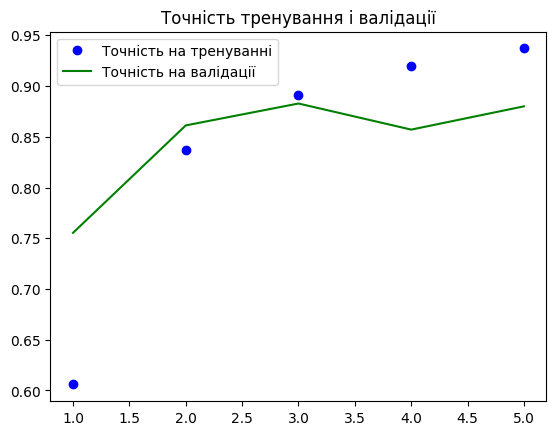

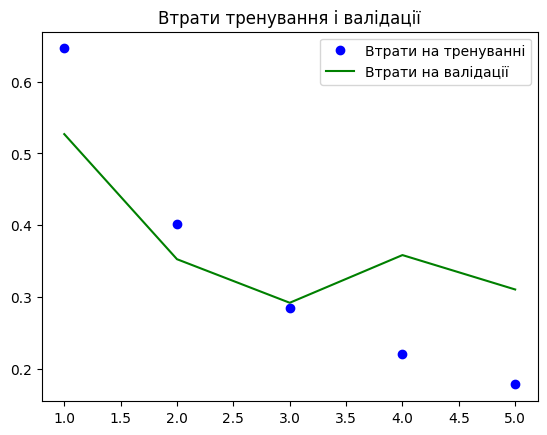

782/782 [==============================] - 39s 48ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
...
= DRNN-16-sigmoid-rmsprop:
782/782 [==============================] - 38s 49ms/step - loss: 0.3212 - acc: 0.8755
Test Loss: 0.3212
Test Accuracy: 0.8755

DRNN-16-SIGMOID-ADAM:


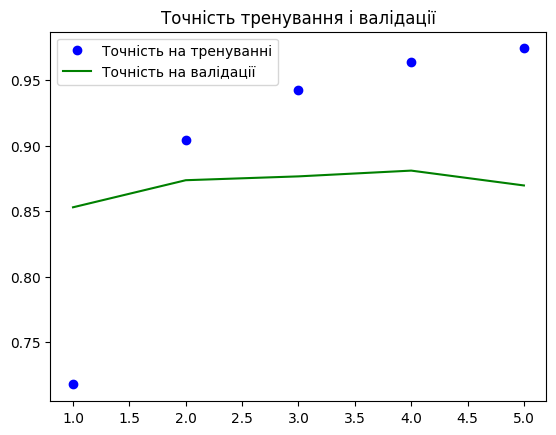

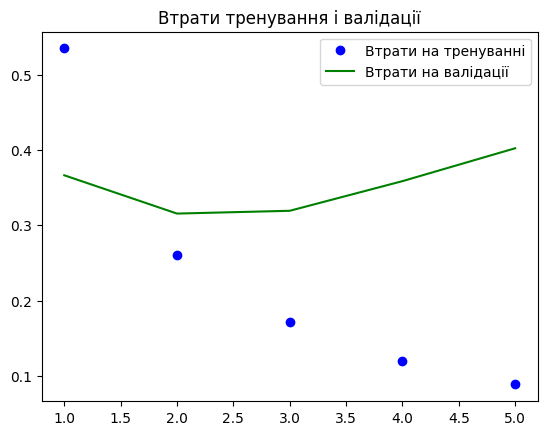

782/782 [==============================] - 39s 48ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
...
= DRNN-16-sigmoid-adam:
782/782 [==============================] - 38s 48ms/step - loss: 0.4276 - acc: 0.8615
Test Loss: 0.4276
Test Accuracy: 0.8615

DRNN-32-SIGMOID-RMSPROP:


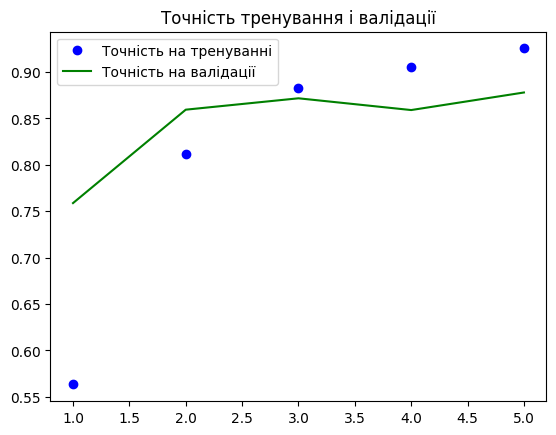

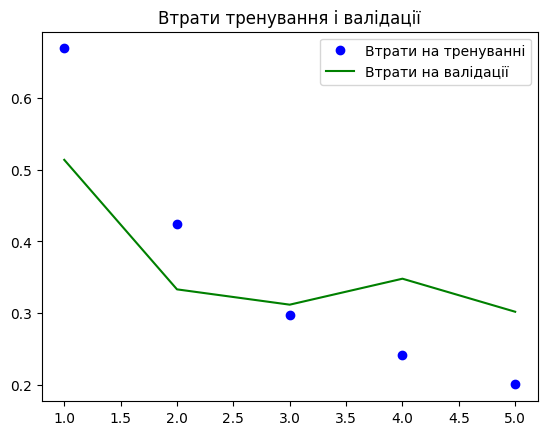

782/782 [==============================] - 48s 60ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
...
= DRNN-32-sigmoid-rmsprop:
782/782 [==============================] - 48s 61ms/step - loss: 0.3141 - acc: 0.8746
Test Loss: 0.3141
Test Accuracy: 0.8746

DRNN-32-SIGMOID-ADAM:


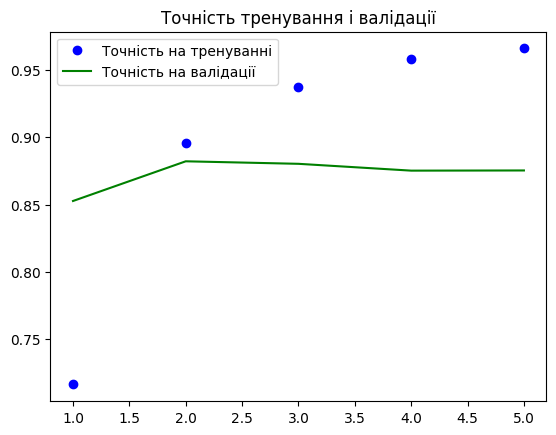

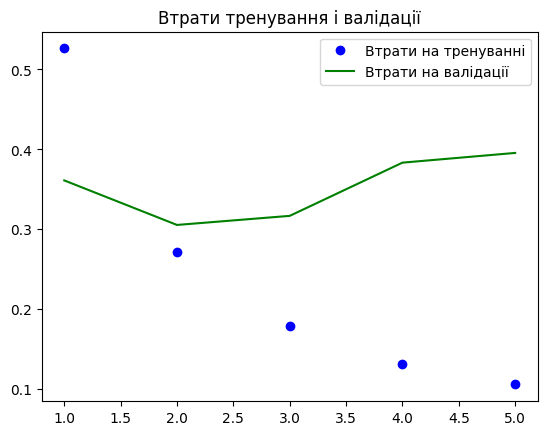

782/782 [==============================] - 48s 60ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
...
= DRNN-32-sigmoid-adam:
782/782 [==============================] - 47s 61ms/step - loss: 0.4281 - acc: 0.8647
Test Loss: 0.4281
Test Accuracy: 0.8647

DRNN-64-SIGMOID-RMSPROP:


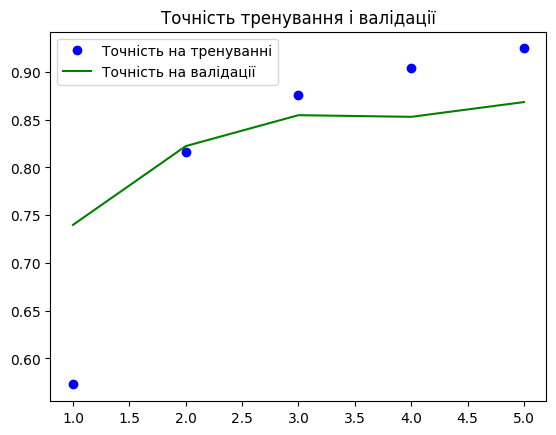

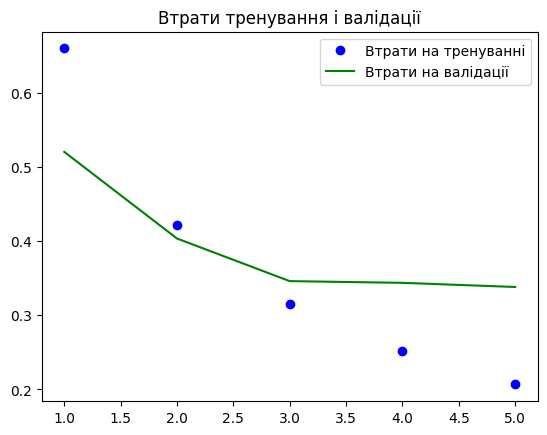

782/782 [==============================] - 72s 91ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
...
= DRNN-64-sigmoid-rmsprop:
782/782 [==============================] - 72s 92ms/step - loss: 0.3415 - acc: 0.8646
Test Loss: 0.3415
Test Accuracy: 0.8646

DRNN-64-SIGMOID-ADAM:


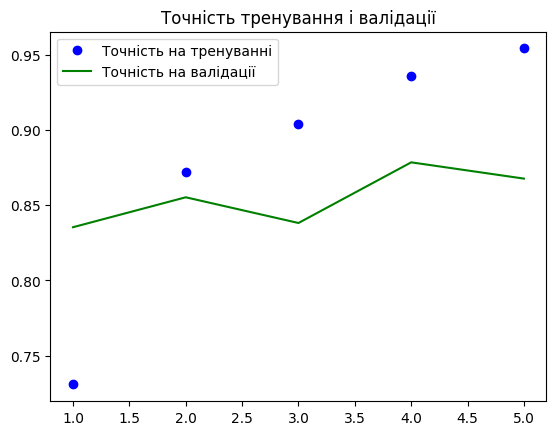

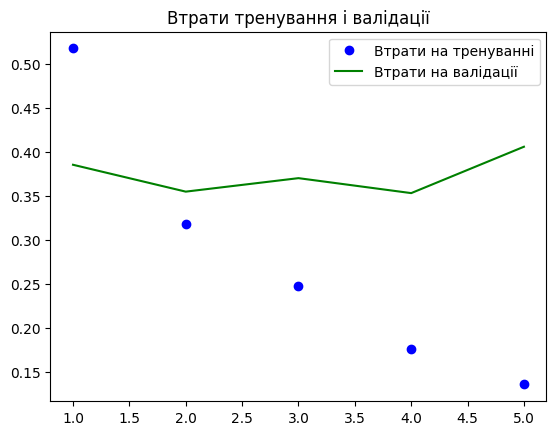

782/782 [==============================] - 72s 91ms/step
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
...
= DRNN-64-sigmoid-adam:
782/782 [==============================] - 72s 91ms/step - loss: 0.4411 - acc: 0.8567
Test Loss: 0.4411
Test Accuracy: 0.8567


In [ ]:
for model, history in all_models_and_history_DRNN:
    print(f'\n{model.name.upper()}:')
    draw_history(history)
    model_acc_by_test_DRNN[model.name] = predictions_by_model(model, input_test, labels_test)

In [ ]:
model_acc_by_test_DRNN

{'DRNN-8-sigmoid-rmsprop': 0.8469600081443787,
 'DRNN-8-sigmoid-adam': 0.8601999878883362,
 'DRNN-16-sigmoid-rmsprop': 0.8755199909210205,
 'DRNN-16-sigmoid-adam': 0.8614799976348877,
 'DRNN-32-sigmoid-rmsprop': 0.8745999932289124,
 'DRNN-32-sigmoid-adam': 0.8646799921989441,
 'DRNN-64-sigmoid-rmsprop': 0.8646000027656555,
 'DRNN-64-sigmoid-adam': 0.856719970703125}

Порівняємо результати:

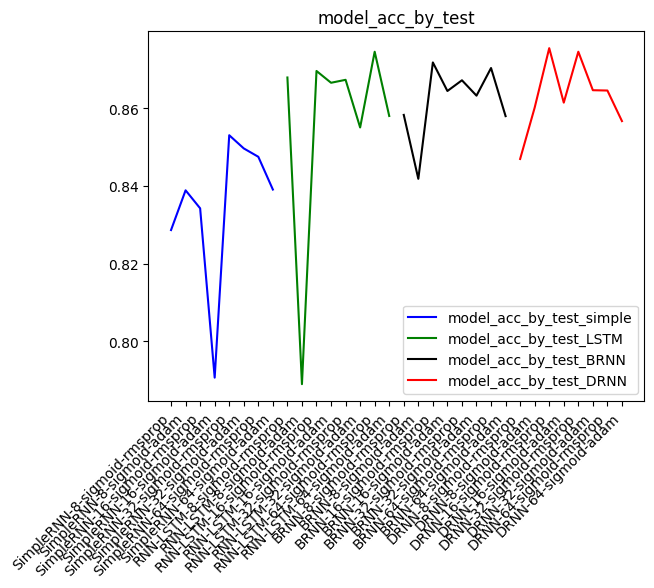

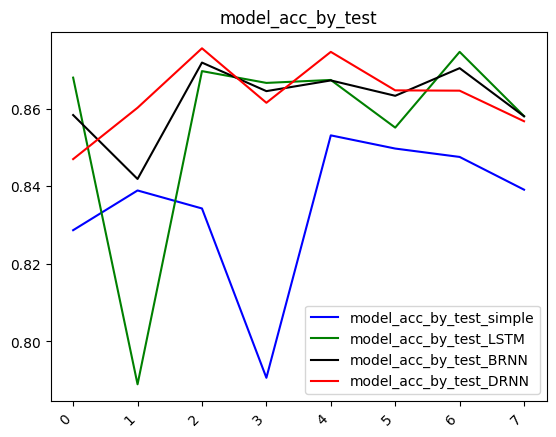

In [ ]:
all_models = range(len(model_acc_by_test_simple))

plt.plot(model_acc_by_test_simple.keys(), model_acc_by_test_simple.values(), 'b', label='model_acc_by_test_simple')
plt.plot(model_acc_by_test_LSTM.keys(), model_acc_by_test_LSTM.values(), 'g', label='model_acc_by_test_LSTM')
plt.plot(model_acc_by_test_BRNN.keys(), model_acc_by_test_BRNN.values(), 'k', label='model_acc_by_test_BRNN')
plt.plot(model_acc_by_test_DRNN.keys(), model_acc_by_test_DRNN.values(), 'r', label='model_acc_by_test_DRNN')

plt.xticks(rotation=45, ha='right')
plt.title('model_acc_by_test')
plt.legend()

plt.figure()

plt.plot(all_models, model_acc_by_test_simple.values(), 'b', label='model_acc_by_test_simple')
plt.plot(all_models, model_acc_by_test_LSTM.values(), 'g', label='model_acc_by_test_LSTM')
plt.plot(all_models, model_acc_by_test_BRNN.values(), 'k', label='model_acc_by_test_BRNN')
plt.plot(all_models, model_acc_by_test_DRNN.values(), 'r', label='model_acc_by_test_DRNN')

plt.xticks(rotation=45, ha='right')
plt.title('model_acc_by_test')
plt.legend()

plt.show()

##### __`RESULTS` & `CONCLUSIONS`__

Якщо загалом:<br>
Очевидно, що звичайні `прості рекурентні нейромережі` мають помітно меншу точніть на тестових вибірках, хоча набагато швидше тренуються за інші (набір моделей `7`хв проти 15, 19, 41).<br>
Звичайні `LSTM` мають трохи кращу точність, але і повільніше тренуються (`15`хв набір моделей).<br>
`BRNN` мають ще трішки кращу точніть, але ще повільніше тренуєтюся (набір моделей - `19` хв).<br>
`DRNN` загалом мають найбільші точності, але ще набагато довше тренуються (набір моделей - `41`хв).<br>

Якщо більш-детально розглянути моделі на позиції 2 (`16-rmsprop`), враховуючи відсутність перенавчання - це добре видно:

In [ ]:
for model in (model_acc_by_test_simple, model_acc_by_test_LSTM, model_acc_by_test_BRNN, model_acc_by_test_DRNN):
    [print(f'{key}:\t {value:.4f}') for num, (key, value) in enumerate(model.items()) if num == 2]

SimpleRNN-16-sigmoid-rmsprop:	 0.8342
RNN-LSTM-16-sigmoid-rmsprop:	 0.8696
BRNN-16-sigmoid-rmsprop:	 0.8718
DRNN-16-sigmoid-rmsprop:	 0.8755


## __Using Pipeline__:

In [16]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.8 MB/s eta 0:00:00


In [17]:
from transformers import pipeline


pipe = pipeline('sentiment-analysis')
pipe  # TextClassificationPipeline

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [18]:
pipe('full cake')  # [{'label': 'NEGATIVE', 'score': 0.9435901641845703}]

[{'label': 'POSITIVE', 'score': 0.9977794289588928}]

In [19]:
def get_binary_predict_pipe(sample) -> int:  # max 512 tokens in pipe
  decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in sample[:400]])

  return 1 if pipe(decoded_review)[0]['label'] == 'POSITIVE' else 0

In [20]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

binary_predictions = [get_binary_predict_pipe(sample) for sample in input_test]

In [21]:
for i in range(5):
  print(f'Прогнозоване: {binary_predictions[i]}, Фактичне: {labels_test[i]}')

Прогнозоване: 0, Фактичне: 0
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 0, Фактичне: 1


In [22]:
m = tf.keras.metrics.Accuracy()
m.update_state(binary_predictions, labels_test)
m.result().numpy()

0.54544

In [23]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.9 MB/s eta 0:00:00


In [24]:
import evaluate

accuracy = evaluate.load('accuracy')

In [25]:
accuracy.compute(references=binary_predictions, predictions=labels_test)['accuracy']

0.54544

Шось точність гірша за рекурентні нейромережі, мабуть треба частково перетреновувати, або якось перепідготувати датасет...